# Modeling
Matthew Mandel Hemsley

### Remember: Churn in this dataset represents individuals who left within the last month
Additionally, Accuaracy and Precision will be our most important metrics as we are attempting to minimize Type 2 Errors

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
churn_df = pd.read_csv('./data/clean_churn.csv')

To begin, let's review our dataset and make sure it imported correctly.

In [3]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,0,1,0,1,0,1,2,1,...,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,2,1,2,...,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,0,0,0,2,1,2,2,1,...,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,0,0,0,0,45,0,2,1,2,...,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,1,0,0,0,2,1,1,1,1,...,0,1,0,1,0,0,0,0,1,0


In [4]:
#Setting index to customerID
churn_df.set_index('customerID',inplace=True)

Let's take a look at each feature and it's corresponding coefficent. First however we should discuss the impact of our imbalanced churn class. Since we know we have imbalanced classes, we should be careful at how much we value each coefficient's impact on our model. We will be using the StatsModel API to create a very quick summary of our dataset to examine before creating our first proper model.

In [5]:
### Logistic Coefficent Analysis
results = sm.Logit(churn_df['Churn'],churn_df.drop(columns=['Churn'])).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7008
Method:                           MLE   Df Model:                           23
Date:                Wed, 12 May 2021   Pseudo R-squ.:                  0.2845
Time:                        21:14:11   Log-Likelihood:                -2913.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
gender                                      0.0218

### What does it all mean?
There's a lot to unpack above, so we are just going to focus on the big take aways. While we can infer the impact of a feature on churn using their coefficents, let's look at the features with the most impactful z-scores, which we can use as statistical evidence of their relevance to predicting our customer churn.

<ul>
<li><b> SeniorCitizen: </b> 2.564 </li>
    The strong indicator that being a Senior Citizen is statistically relevant to predicting churn is somewhat surprising. This could suggest a weakness in marketing towards that demographic, or these customers could be unfortunately passing away due to natural causes. A deeper examination into the user habits of these customers could provide new insights that would explain this.
<li><b> Dependents: </b> -1.655 </li>
    
<li><b> tenure :</b> -9.716 </li>
    We explored this during our EDA, but this z-score provides us with further statistical evidence that indicates the importance of long-term users in avoiding churn.
<li><b> PhoneService :</b> 9.93839 </li>
<li><b> OnlineSecurity :</b> -0.20542 </li>
<li><b> OnlineBackup :</b> 0.02604 </li>
<li><b> DeviceProtection :</b> 0.14737 </li>
<li><b> TechSupport :</b> -0.1805 </li>
<li><b> StreamingTV :</b> 0.59051 </li>
<li><b> StreamingMovies :</b> 0.5993 </li>
<li><b> PaperlessBilling :</b> 0.34235 </li>
<li><b> MonthlyCharges :</b> -0.04034 </li>
<li><b> TotalCharges :</b> 0.00033 </li>

<li><b> MultipleLines_No :</b>-2.60859</li>
<li><b> MultipleLines_No phone service :</b> 7.15833   </li>
<li><b> MultipleLines_Yes :</b> -2.1602 </li>
<li><b> InternetService_DSL :</b> -7.62672 </li>
<li><b> InternetService_Fiber optic :</b> -5.87925 </li>
<li><b> InternetService_No :</b> -8.43571 </li>
<li><b> Contract_Month-to-month :</b> 0.6736 </li>
<li><b> Contract_One year :</b> 0.0128 </li>
<li><b> Contract_Two year :</b> -0.68351 </li>
<li><b> PaymentMethod_Bank transfer (automatic) :</b> -0.03905 </li>
<li><b> PaymentMethod_Credit card (automatic) :</b> -0.12684 </li>
<li><b> PaymentMethod_Electronic check :</b> 0.26542</li>
    <li><b>PaymentMethod_Mailed check:</b> -0.09664 </li>
</ul>

## Train/Test Split
We will be using all the features in our dataset to predict our y, Churn. Additionally, we will be stratifing during our train/test split in order to offset our imbalanced Churn class.

In [6]:
#Train/Test Split
X = churn_df.drop(columns=['Churn'])
y = churn_df['Churn']
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, stratify=y)

In [7]:
#Scaling our data
stan = StandardScaler()
X_sc_train = stan.fit_transform(X_train)
X_sc_test = stan.transform(X_test)

## Logistic Regression
We are just going to fit to a standard logistic regression model to create a baseline for us to compare our future models with. While we could simply use a standard of 50%, one of the goals of this notebook is to compare models and statistical techiniques across the same churn dataset. As we will see, a logistic regression model with default parameters scores very well on our dataset as is, so our challenge will be to not only develop a better model, but also identify which features contribute to higher accuracy and recall metrics, which will be our primary comparisons for our models.

In [8]:
#Instantiate/Fit/Score Default Logistic Regression Model
logit = LogisticRegression()
logit.fit(X_sc_train,y_train)

print(f'Training Accuracy: {logit.score(X_sc_train,y_train):.2%}')
print(f'Testing Accuracy: {logit.score(X_sc_test,y_test):.2%}')

Training Accuracy: 80.39%
Testing Accuracy: 80.60%


We can see from these scores that not only does our logistic regression model predict 80% of the varience of our data, but our model is relatively fit, though clearly there is room for improvement. 

In [9]:
#Generate Predictions
preds=logit.predict(X_sc_test)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1291
           1       0.65      0.57      0.61       467

    accuracy                           0.81      1758
   macro avg       0.75      0.73      0.74      1758
weighted avg       0.80      0.81      0.80      1758



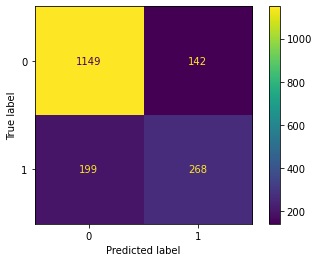

In [10]:
print(classification_report(y_test,preds))
cm = confusion_matrix(y_test,preds)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = logit.classes_).plot();

The above confusion matrix shows a breakdown of our predictions. Our model predicted we would churn 410 customers. Of those predicted, 268 were correct. 199 customers churned out of 1149 we predicted would not churn. Though we have the option to tune our model, a quick gridsearch will reveal that our defaults actually produce the best result.

In [11]:
logit_params = {
    'penalty':['l1','l2'],
    'class_weight':['balanced',None],
    'solver':['lbfgs','liblinear','']
}

In [27]:
logit_best = GridSearchCV(LogisticRegression(), logit_params,cv=10,verbose=0,n_jobs=3).fit(X_sc_train,y_train);

In [13]:
print(f'Our best parameters: {logit_best.best_params_}')
print(f'Out best score: {round(logit_best.best_score_,3)}')

Our best parameters: {'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Out best score: 0.804


## KNearest Neighbors

In [14]:
#KNearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_sc_train,y_train)

print(f'Training Score: {knn.score(X_sc_train,y_train):.2%}')
print(f'Test Score: {knn.score(X_sc_test,y_test):.2%}')

Training Score: 83.67%
Test Score: 75.03%


              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1291
           1       0.53      0.54      0.53       467

    accuracy                           0.75      1758
   macro avg       0.68      0.68      0.68      1758
weighted avg       0.75      0.75      0.75      1758



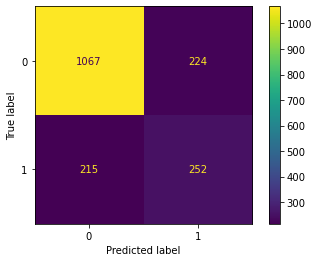

In [15]:
#Generate Predictions
preds=knn.predict(X_sc_test)
print(classification_report(y_test,preds))
cm = confusion_matrix(y_test,preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = knn.classes_).plot();

One of the first things we notice, is that our model performed worse than our logistic regression. Let's take a look at tuning some of our parameters to see if we can close that performance gap.

In [16]:
#KNearest Neighbors Parameter Dictionary
knn_params = {
    'n_neighbors':range(10,101,10),
    'weights':['uniform','distance']}

In [17]:
#GridSearch
knn_best = GridSearchCV(KNeighborsClassifier(), knn_params,cv=10,verbose=1, n_jobs=3).fit(X_sc_train,y_train);

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   24.8s finished


In [18]:
print(f'Our best parameters: {knn_best.best_params_}')
print(f'Out best score: {round(knn_best.best_score_,3)}')`

Our best parameters: {'n_neighbors': 60, 'weights': 'uniform'}
Out best score: 0.791


We can see that even with our gridsearch, we didn't see much improvement in our model. Let's instantiate a fresh model and fit it one last time to see our final training and test scores.

In [19]:
tuned_knn = KNeighborsClassifier(n_neighbors=60)
tuned_knn.fit(X_sc_train,y_train)

print(f'Training Score: {tuned_knn.score(X_sc_train,y_train):.2%}')
print(f'Test Score: {tuned_knn.score(X_sc_test,y_test):.2%}')

Training Score: 79.79%
Test Score: 78.95%


## Support Vector Machine (SVM)
The final model we are going to examine our churn dataset with is a support vector machine. Support vector machines are very powerful models that generally perform very well. Let's take a look and see!

In [23]:
# Instantiate SVM.
svc = SVC()

In [24]:
#Fit
svc.fit(X_sc_train,y_train)

print(f'Training Score: {svc.score(X_sc_train,y_train):.2%}')
print(f'Test Score: {svc.score(X_sc_test,y_test):.2%}')

Training Score: 81.82%
Test Score: 80.03%


Already we can see that this is scoring comparitive to our logistic regression model.

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1291
           1       0.66      0.52      0.58       467

    accuracy                           0.80      1758
   macro avg       0.75      0.71      0.73      1758
weighted avg       0.79      0.80      0.79      1758



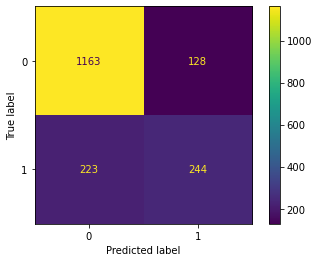

In [26]:
#Generate Predictions
preds=svc.predict(X_sc_test)
print(classification_report(y_test,preds))
cm = confusion_matrix(y_test,preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = svc.classes_).plot();

In [37]:
svc_params = {
    'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'gamma':['scale','auto'],
    'class_weight':['balanced',None],
    'break_ties':[True,False]
}

In [38]:
#GridSearch
svc_best = GridSearchCV(SVC(), svc_params,cv=10,verbose=1, n_jobs=3).fit(X_sc_train,y_train);

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   12.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   48.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 800 out of 800 | elapsed:  3.2min finished


In [39]:
print(f'Our best parameters: {svc_best.best_params_}')
print(f'Out best score: {round(svc_best.best_score_,3)}')

Our best parameters: {'C': 0.6, 'break_ties': True, 'class_weight': None, 'gamma': 'scale'}
Out best score: 0.804


Unfortunately it looks like even with an extensive gridsearch, we aren't seeing much improvement from our SVM. Looks like we will have to experiment with some feature engineering to increase our model performance.